In [1]:
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, Add,\
                         BatchNormalization, LeakyReLU, Reshape, Flatten, Dense
from keras.optimizer_v1 import Adam
from keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio

from noisifier import Noisifier
from splitter import Splitter
from dataset_preprocessor import PolarSpectrogramExtractor, AudioDatasetFromCSV



tf.compat.v1.disable_eager_execution()

# Constants

In [35]:
SAMPLE_RATE = 22050
SAMPLE_LENGTH = 2**16
FRAME_SIZE = 1024
HOP_LENGTH = 256
VALIDATION_SIZE = 0.1
BATCH_SIZE = 32
AUDIO_DIR = "./audio/guitar_samples/"
HARM_NOISE_DIR = "./audio/harm_noise/"
ENV_NOISE_DIR = "./audio/esc_50/"
TARGET_SAVE_DIR = "./audio/target/"
NOISE_SAVE_DIR = "./audio/noise/"
MIXED_SAVE_DIR = "./audio/mixed/"

# Instantiate Splitter

In [3]:
splitter_params = {
    'target_sr': SAMPLE_RATE,
    'target_length': SAMPLE_LENGTH
}

splitter = Splitter(**splitter_params)

# Split Target and Noise Files

In [4]:
splitter.process_audio_files(directory=AUDIO_DIR, save_dir=TARGET_SAVE_DIR)
splitter.process_audio_files(directory=HARM_NOISE_DIR, save_dir=NOISE_SAVE_DIR)
splitter.process_audio_files(directory=ENV_NOISE_DIR, save_dir=NOISE_SAVE_DIR)


        2642 2.972154195011338-second audio files created in:
        ./audio/target/
        

        2612 2.972154195011338-second audio files created in:
        ./audio/noise/
        

        5012 2.972154195011338-second audio files created in:
        ./audio/noise/
        


# Instantiate Noisifier

In [5]:
noisifier_params = {
    'audio_dir': TARGET_SAVE_DIR, 
    'noise_dir': NOISE_SAVE_DIR, 
    'save_dir': MIXED_SAVE_DIR, 
    'sr': SAMPLE_RATE,
    'snr_range': [0, 5]
}

noisifier = Noisifier(**noisifier_params)

# Add Noise to Target Files

In [6]:
noisifier.noisify()

Please specify a name for the metadata csv file noise_metadata


Metadata saved at location: ./audio/noise_metadata.csv


# Instantiate Polar Spectrogram Extractor

In [7]:
extractor_params = {
    'frame_size': FRAME_SIZE,
    'hop_length': HOP_LENGTH
}
extractor = PolarSpectrogramExtractor(**extractor_params)

# Instantiate Custom Dataset Object

In [12]:
dataset_params = {
    'spectrogram_extractor': extractor,
    'metadata_csv': './audio/noise_metadata.csv',
    'validation_size': VALIDATION_SIZE,
    'sr': SAMPLE_RATE,
    'prepared': False
}

data = AudioDatasetFromCSV(**dataset_params)

# Preprocess Data

In [13]:
data.prepare_dataset()

# Make Train and Test Sets

In [14]:
data.train_test_split()

In [15]:
data.x_train.shape

(2377, 512, 256, 2)

# Skip Connection Autoencoder

In [150]:
input_spectrogram = Input(shape=(512, 256, 1))
# Encoder
# strides of 2,2 works like max pooling and downsamples the image
y = Conv2D(32, (3, 3), padding='same',strides =(2,2))(input_spectrogram)
y = LeakyReLU()(y)
y = Conv2D(64, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
y2 = Conv2D(128, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y2)
y = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
y1 = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y1)
y = Conv2D(512, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
y = Conv2D(1024, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
dims = y.shape # shape of the final convolutional layer
x = Flatten()(y)
latent = Dense(128,activation='relu')(x) # bottleneck layer to control the information flow

In [151]:
# helper function 
def lrelu_bn(inputs):
    lrelu = LeakyReLU()(inputs)
    bn = BatchNormalization()(lrelu)
    return bn   

In [152]:
# Decoder
y = Dense(np.prod(dims[1:]), activation='relu')(latent) # accepting the output from the bottleneck layer
y = Reshape((dims[1], dims[2], dims[3]))(y) 
y = Conv2DTranspose(1024, (3,3), padding='same')(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(512, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
y= Add()([y1, y]) # remove to run model without skip connections
y = lrelu_bn(y)  # remove to run model without skip connections
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y) 
y = Conv2DTranspose(128, (3,3), padding='same',strides=(2,2))(y)   
y= Add()([y2, y]) # remove to run model without skip connections
y = lrelu_bn(y) # remove to run model without skip connections
y = Conv2DTranspose(64, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(32, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same',strides=(2,2))(y)

In [19]:
model = Model(input_spectrogram, y, name="skip_autoencoder")

In [153]:
model_phi = Model(input_spectrogram, y, name="phi_autoencoder")

In [20]:
model.summary()

Model: "skip_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                  

In [30]:
def mag_only(dataset):
    mag_only = np.stack([x[..., 0] for x in dataset])
    exp_mag_only = mag_only[..., np.newaxis]
    return exp_mag_only

In [34]:
X_train = mag_only(data.x_train)
Y_train = mag_only(data.y_train)
X_test = mag_only(data.x_test)
Y_test = mag_only(data.y_test)

# Train Model

In [37]:
model.compile(
    loss="mse",
    optimizer=Adam(lr=0.0001)
)

In [39]:
results = model.fit(
    x=X_train,
    y=Y_train,
    validation_data=(X_test, Y_test),
    epochs=75,
    batch_size=BATCH_SIZE
)

Train on 2377 samples, validate on 265 samples
Epoch 1/75
2377/2377 [==============================] - ETA: 0s - loss: 0.1092

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-06-08 03:57:10.748944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2377/2377 [==============================] - 50s 21ms/sample - loss: 0.1092 - val_loss: 0.1498
Epoch 2/75
2377/2377 [==============================] - 46s 19ms/sample - loss: 0.0311 - val_loss: 0.0968
Epoch 3/75
2377/2377 [==============================] - 45s 19ms/sample - loss: 0.0211 - val_loss: 0.0666
Epoch 4/75
2377/2377 [==============================] - 45s 19ms/sample - loss: 0.0179 - val_loss: 0.0438
Epoch 5/75
2377/2377 [==============================] - 44s 19ms/sample - loss: 0.0153 - val_loss: 0.0321
Epoch 6/75
2377/2377 [==============================] - 44s 19ms/sample - loss: 0.0137 - val_loss: 0.0231
Epoch 7/75
2377/2377 [==============================] - 44s 19ms/sample - loss: 0.0124 - val_loss: 0.0184
Epoch 8/75
2377/2377 [==============================] - 44s 19ms/sample - loss: 0.0113 - val_loss: 0.0137
Epoch 9/75
2377/2377 [==============================] - 44s 18ms/sample - loss: 0.0105 - val_loss: 0.0132
Epoch 10/75
2377/2377 [==============================] - 

In [46]:
model.save_weights("./weights_skip_smaller.h5")

2023-06-08 04:51:36.422745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 04:51:36.472353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 04:51:36.655032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 04:51:36.668381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 04:51:36.678065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 04:51:36.686999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 04:51:36.695929: I tensorflow/core/grappler/optimizers/cust

In [73]:

X_test_phi.shape

(265, 512, 256)

In [175]:
reconstructed_specs

array([[[0.43403605, 0.39929384, 0.32546657, ..., 0.2549327 ,
         0.27428052, 0.2975532 ],
        [0.4344756 , 0.38353735, 0.29636085, ..., 0.24449454,
         0.27424315, 0.29825592],
        [0.41295734, 0.3646482 , 0.2431522 , ..., 0.21064201,
         0.20877713, 0.25372723],
        ...,
        [0.06064385, 0.02020476, 0.00255   , ..., 0.00350578,
         0.00736799, 0.02758738],
        [0.06118039, 0.02477792, 0.00486895, ..., 0.00379962,
         0.00811478, 0.02967931],
        [0.05654246, 0.02353836, 0.00453062, ..., 0.00860534,
         0.01391116, 0.03943187]],

       [[0.5007211 , 0.46611777, 0.38702884, ..., 0.3450348 ,
         0.36606163, 0.3943223 ],
        [0.49942154, 0.46163186, 0.4199396 , ..., 0.3753401 ,
         0.37861112, 0.42714828],
        [0.50362104, 0.48591173, 0.37144688, ..., 0.33309522,
         0.32637313, 0.37522942],
        ...,
        [0.13072337, 0.06149324, 0.0129564 , ..., 0.00908337,
         0.02585694, 0.10414022],
        [0.1

(512, 256)
(512, 256)
(512, 256, 2)


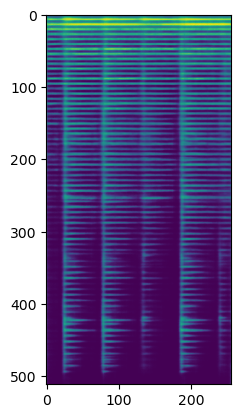

In [475]:
spec = np.load(data.metadata.loc['20.wav']['mixed_spec'])[...,0][np.newaxis,...,np.newaxis]
plt.imshow(spec[0,...,0])
phi = np.load(data.metadata.loc['20.wav']['mixed_spec'])[...,1]
new_spec = model.predict(spec)[0,...,0]
plt.imshow(new_spec)
print(new_spec.shape)
print(phi.shape)

form_spec = np.stack([new_spec, phi], axis=-1)
print(form_spec.shape)

minval = data.metadata.loc['20.wav']['mixed_minmax']['min']
maxval = data.metadata.loc['20.wav']['mixed_minmax']['min']

signal = extractor.recover_signal(form_spec, minval, maxval)

display_audio(signal)

In [288]:
new_spec = model.predict(spec)

In [531]:
# 30 146 35 96 128 122 26 44 227 205 96 111 79

128
./audio/noise/acoustic_performance_split_4.wav
Noisy Audio


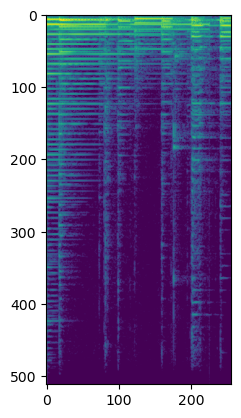

Original Audio


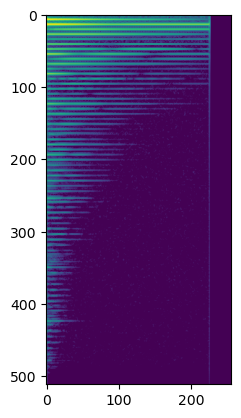

Denoised Audio


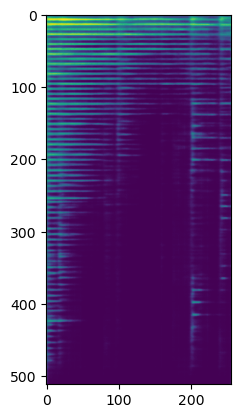

In [553]:
i = 128 #np.random.randint(low=0, high=len(data.x_test))
print(i)

recon_phi = recon_phis[i][...,0]
orig_phi = data.y_test[i][...,1]
mixed_phi = data.x_test[i][...,1]


recon_phase_spec = np.stack([reconstructed_specs[i], recon_phi], axis=-1)
orig_phase_spec = np.stack([reconstructed_specs[i], orig_phi], axis=-1)
mixed_phase_spec = np.stack([reconstructed_specs[i], mixed_phi], axis=-1)

minval, maxval = get_minmax_vals(data, i)

orig_audio = extractor.recover_signal(data.y_test[i], minval, maxval)
mixed_audio = extractor.recover_signal(data.x_test[i], minval, maxval)
orig_phase_signal = extractor.recover_signal(orig_phase_spec, minval, maxval)
mixed_phase_signal = extractor.recover_signal(mixed_phase_spec, minval, maxval)
print("Noisy Audio")
plt.imshow(data.x_test[i][...,0])
plt.show()
display_audio(mixed_audio)
print("Original Audio")
plt.imshow(data.y_test[i][...,0])
plt.show()
display_audio(orig_audio)
print("Denoised Audio")
plt.imshow(reconstructed_specs[i])
plt.show()
display_audio(orig_phase_signal)
display_audio(mixed_phase_signal)

In [433]:
def get_minmax_vals(dataset, index, signal_type='mixed'):
    
    if signal_type not in ('mixed', 'noise', 'orig'):
        signal_type = input(
            """
            signal_type must be one of the following:
            ('mixed', 'noise', 'orig').
            Please specify the signal type.
            """)
    column = signal_type + '_minmax'
    key = dataset.x_test_file_names[index].split("/")[-1]
    minmax = dataset.metadata.loc[key, column]
    print(dataset.metadata.loc[key, 'noise_file'])
    return minmax['min'], minmax['max']
    
    

In [119]:
def get_recovered_audio(specs, model, dataset, index, signal_type, extractor):
    
    minval, maxval = get_minmax_vals(dataset, index, signal_type)
    recovered_signal = extractor.recover_signal(specs[index], minval, maxval)
    mixed_signal = extractor.recover_signal(dataset.x_test[index], minval, maxval)
    display_audio(mixed_signal)
    display_audio(recovered_signal)
    #return recovered_signal, mixed_signal
    
    

In [159]:
def get_recovered_audio(specs, phis, model, dataset, index, signal_type, extractor):
    
    minval, maxval = get_minmax_vals(dataset, index, signal_type)
    recovered_signal = extractor.recover_signal(specs[index], minval, maxval)
    mixed_signal = extractor.recover_signal(dataset.x_test[index], minval, maxval)
    display_audio(mixed_signal)
    display_audio(recovered_signal)
    #return recovered_signal, mixed_signal
    
    

In [137]:
get_recovered_audio(reformatted_specs, model, data, 18, 'mixed', extractor)

In [114]:
min_val, max_val = get_minmax_vals(data, 0)

In [116]:
display_audio(signal), display_audio(rec_signal)

(None, None)

In [100]:
rec_signal = extractor.recover_signal(reformatted_specs[0],
                                      min_val,
                                      max_val)

noise_signal = extractor.recover_signal(data.x_test[0],
                                       min_val, 
                                       max_val)

In [103]:
def display_audio(signal):
    
    return display(Audio(data = signal, rate = SAMPLE_RATE))

In [104]:
display_audio(rec_signal)
display_audio(noise_signal)

# 2 Channel

In [40]:
input_spectrogram = Input(shape=(512, 256, 2))
# Encoder
# strides of 2,2 works like max pooling and downsamples the image
y = Conv2D(32, (3, 3), padding='same',strides =(2,2))(input_spectrogram)
y = LeakyReLU()(y)
y = Conv2D(64, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
y2 = Conv2D(128, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y2)
y = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
y1 = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y1)
y = Conv2D(512, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
y = Conv2D(1024, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
dims = y.shape # shape of the final convolutional layer
x = Flatten()(y)
latent = Dense(128,activation='relu')(x) # bottleneck layer to control the information flow

In [41]:
# helper function 
def lrelu_bn(inputs):
    lrelu = LeakyReLU()(inputs)
    bn = BatchNormalization()(lrelu)
    return bn   

In [42]:
# Decoder
y = Dense(np.prod(dims[1:]), activation='relu')(latent) # accepting the output from the bottleneck layer
y = Reshape((dims[1], dims[2], dims[3]))(y) 
y = Conv2DTranspose(1024, (3,3), padding='same')(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(512, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
y= Add()([y1, y]) # remove to run model without skip connections
y = lrelu_bn(y)  # remove to run model without skip connections
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y) 
y = Conv2DTranspose(128, (3,3), padding='same',strides=(2,2))(y)   
y= Add()([y2, y]) # remove to run model without skip connections
y = lrelu_bn(y) # remove to run model without skip connections
y = Conv2DTranspose(64, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(32, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(2, (3,3), activation='sigmoid', padding='same',strides=(2,2))(y)

In [43]:
model2 = Model(input_spectrogram, y, name="skip_autoencoder")

In [44]:
model2.summary()

Model: "skip_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 128, 32  608         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (None, 256, 128, 32  0           ['conv2d_7[0][0]']               
                                )                                                  

In [45]:
model2.compile(
    loss="mse",
    optimizer=Adam(lr=0.0001)
)

In [47]:
model2.fit(
    x=data.x_train,
    y=data.y_train,
    validation_data=(data.x_test, data.y_test),
    epochs=75,
    batch_size=BATCH_SIZE
)

Train on 2377 samples, validate on 265 samples
Epoch 1/75


2023-06-08 04:51:37.474448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 04:51:37.549677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 04:51:37.645345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2377/2377 [==============================] - ETA: 0s - loss: 1.7999

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-06-08 04:52:36.142193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2377/2377 [==============================] - 62s 26ms/sample - loss: 1.7999 - val_loss: 1.7025
Epoch 2/75
2377/2377 [==============================] - 47s 20ms/sample - loss: 1.6782 - val_loss: 1.6677
Epoch 3/75
2377/2377 [==============================] - 47s 20ms/sample - loss: 1.6554 - val_loss: 1.6624
Epoch 4/75
2377/2377 [==============================] - 47s 20ms/sample - loss: 1.6510 - val_loss: 1.6573
Epoch 5/75
2377/2377 [==============================] - 47s 20ms/sample - loss: 1.6486 - val_loss: 1.6553
Epoch 6/75
2377/2377 [==============================] - 47s 20ms/sample - loss: 1.6471 - val_loss: 1.6571
Epoch 7/75
2377/2377 [==============================] - 47s 20ms/sample - loss: 1.6462 - val_loss: 1.6530
Epoch 8/75
2377/2377 [==============================] - 47s 20ms/sample - loss: 1.6453 - val_loss: 1.6553
Epoch 9/75
2377/2377 [==============================] - 47s 20ms/sample - loss: 1.6447 - val_loss: 1.6526
Epoch 10/75
2377/2377 [==============================] - 

In [48]:
model2.save_weights("./weights_skip_2ch.h5")

2023-06-08 05:52:12.129298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 05:52:12.145111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 05:52:12.161543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 05:52:12.176059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 05:52:12.189008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 05:52:12.202461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-08 05:52:12.226359: I tensorflow/core/grappler/optimizers/cust

In [138]:
rec_2ch = model2.predict(data.x_test)

/Users/jacksonnelson/miniconda3/envs/tf_metal/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-08 10:31:19.505747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [141]:
display_audio(extractor.recover_signal(rec_2ch[0],min_val,max_val))

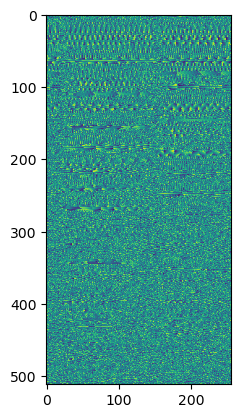

In [158]:
plt.imshow(y_test_phi[0])

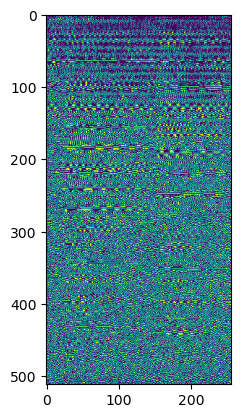

In [157]:
plt.imshow(recon_phi[0])

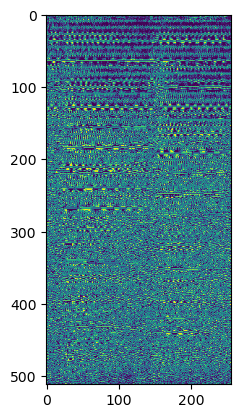

In [143]:
plt.imshow(rec_2ch[0][...,1])

In [149]:
x_train_phi = data.x_train[...,1][...,np.newaxis]
x_test_phi = data.x_test[..., 1][...,np.newaxis]
y_train_phi = data.y_train[...,1][...,np.newaxis]
y_test_phi = data.y_test[...,1][...,np.newaxis]

In [193]:
recon_phis = model_phi.predict(x_test_phi)

In [556]:
x_train_phi = data.x_train[...,1][...,np.newaxis]
y_train_phi = data.y_train[...,1][...,np.newaxis]
x_test_phi = data.x_test[...,1][...,np.newaxis]
x_test_phi = data.x_test[...,1][...,np.newaxis]

In [557]:
input_spectrogram = Input(shape=(512, 256, 1))
# Encoder
# strides of 2,2 works like max pooling and downsamples the image
y = Conv2D(32, (3, 3), padding='same',strides =(2,2))(input_spectrogram)
y = LeakyReLU()(y)
y = Conv2D(64, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
y2 = Conv2D(128, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y2)
y = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
y1 = Conv2D(256, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y1)
y = Conv2D(512, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
y = Conv2D(1024, (3, 3), padding='same',strides =(2,2))(y)
y = LeakyReLU()(y)
dims = y.shape # shape of the final convolutional layer
x = Flatten()(y)
latent = Dense(128,activation='relu')(x) # bottleneck layer to control the information flow

In [558]:
# helper function 
def lrelu_bn(inputs):
    lrelu = LeakyReLU()(inputs)
    bn = BatchNormalization()(lrelu)
    return bn   

In [559]:
# Decoder
y = Dense(np.prod(dims[1:]), activation='relu')(latent) # accepting the output from the bottleneck layer
y = Reshape((dims[1], dims[2], dims[3]))(y) 
y = Conv2DTranspose(1024, (3,3), padding='same')(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(512, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
y= Add()([y1, y]) # remove to run model without skip connections
y = lrelu_bn(y)  # remove to run model without skip connections
y = Conv2DTranspose(256, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y) 
y = Conv2DTranspose(128, (3,3), padding='same',strides=(2,2))(y)   
y= Add()([y2, y]) # remove to run model without skip connections
y = lrelu_bn(y) # remove to run model without skip connections
y = Conv2DTranspose(64, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(32, (3,3), padding='same',strides=(2,2))(y)
y = LeakyReLU()(y)
y = Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same',strides=(2,2))(y)

In [560]:
model_phi = Model(input_spectrogram, y, name="phi_autoencoder")

In [561]:
model_phi.compile(
    loss="mse",
    optimizer=Adam(lr=0.0001)
)

In [564]:
x_train_phi[0]

array([[[ 3.1415925 ],
        [ 3.1415925 ],
        [ 3.1415925 ],
        ...,
        [ 0.        ],
        [ 3.1415925 ],
        [ 3.1415925 ]],

       [[ 0.06883854],
        [ 1.8315777 ],
        [-0.2053642 ],
        ...,
        [-2.023637  ],
        [-0.8656283 ],
        [ 0.8488535 ]],

       [[-3.0424774 ],
        [ 0.18410593],
        [ 3.0393612 ],
        ...,
        [-0.14141007],
        [-0.6608611 ],
        [-2.7537076 ]],

       ...,

       [[-0.11509478],
        [ 1.3103424 ],
        [ 1.1669465 ],
        ...,
        [ 2.8774455 ],
        [-0.85155374],
        [-1.4403567 ]],

       [[-3.0379024 ],
        [ 0.36286342],
        [ 1.0627029 ],
        ...,
        [-0.1199681 ],
        [ 1.3939321 ],
        [-0.05133258]],

       [[ 0.16078456],
        [-1.0980468 ],
        [-1.8999047 ],
        ...,
        [-2.7450674 ],
        [ 2.4279006 ],
        [ 1.5323533 ]]], dtype=float32)

In [563]:
phi_results = model_phi.fit(
    x = x_train_phi,
    y = y_train_phi,
    validation_data=(x_test_phi, y_test_phi),
    epochs=300,
    batch_size=BATCH_SIZE
)

Train on 2377 samples, validate on 265 samples
Epoch 1/300
2377/2377 [==============================] - 46s 19ms/sample - loss: 3.2934 - val_loss: 3.2891
Epoch 2/300
2377/2377 [==============================] - 45s 19ms/sample - loss: 3.2759 - val_loss: 3.2859
Epoch 3/300
2377/2377 [==============================] - 46s 19ms/sample - loss: 3.2726 - val_loss: 3.2839
Epoch 4/300
2377/2377 [==============================] - 45s 19ms/sample - loss: 3.2700 - val_loss: 3.2831
Epoch 5/300
2377/2377 [==============================] - 46s 19ms/sample - loss: 3.2613 - val_loss: 3.2721
Epoch 6/300
2377/2377 [==============================] - 45s 19ms/sample - loss: 3.2434 - val_loss: 3.2540
Epoch 7/300
2377/2377 [==============================] - 46s 19ms/sample - loss: 3.2194 - val_loss: 3.2510
Epoch 8/300
2377/2377 [==============================] - 46s 19ms/sample - loss: 3.1892 - val_loss: 3.2038
Epoch 9/300
2377/2377 [==============================] - 46s 19ms/sample - loss: 3.1583 - val_los

KeyboardInterrupt: 